# Brain Tumor Image Detection

W207: Applied Machine Learning (Fall 2022) <br>
Meng-Kang Kao, Zachary Galante, Milan Dean and Kevin Cahillane <br>
December 6, 2022 <br>

## 1. `Research Question`

Can we predict brain tumor using MRI images?

## 2. `Data`

Kaggle Dataset [link](https://www.kaggle.com/datasets/preetviradiya/brian-tumor-dataset) including 4600 brain images with the binary labels “Healthy” or “Cancer”.


## 3. Import packages

In [1]:
# standard library imports alphabetical
import copy
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import pandas as pd
import seaborn as sns
import warnings

from PIL import Image

# Tensorflow
from keras import models
from keras import layers
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# sklearn
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report

# Visualization
from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap

# Image Hash
from imagehash import average_hash

warnings.filterwarnings("ignore")

## 4. Read Data

### 4.1 Load Image Attributes

In [2]:
# Define image and label file location #
CANCER_IMAGE_PATH = './Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/'
HEALTHY_IMAGE_PATH = './Brain Tumor Data Set/Brain Tumor Data Set/Healthy/'

In [3]:
# for EDA purpose only, read the image attribute.
df = pd.read_csv('metadata_rgb_only.csv')

In [4]:
df.head(5)

,Unnamed: 0,image,class,format,mode,shape
0,0,Cancer (1).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
1,2,Cancer (1).tif,tumor,TIFF,RGB,"(256, 256, 3)"
2,3,Cancer (10).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
3,4,Cancer (10).tif,tumor,TIFF,RGB,"(256, 256, 3)"
4,5,Cancer (100).jpg,tumor,JPEG,RGB,"(512, 512, 3)"


### 4.2 Load Cancer Images
#### Findings:
* Images have different view angles (topdown, side view, and etc.)
* Some images have edge cut-off
* Images have different contrast of background.

Sample of cancer images in data: 2513


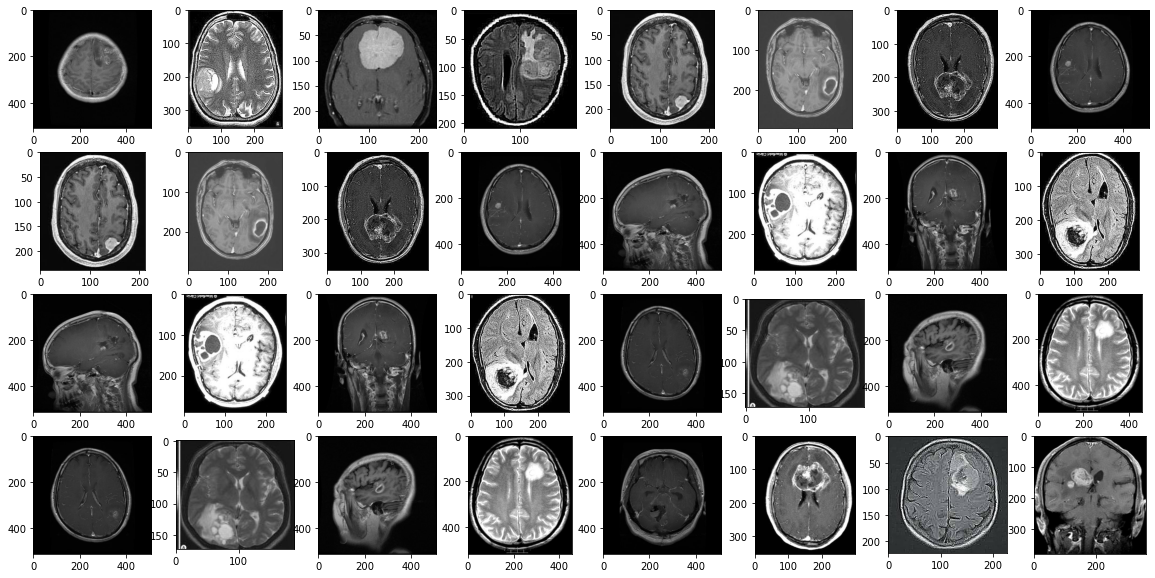

In [5]:
# Read Cancer Images
indx = 0
cancer_images = []

for idx, img in enumerate(os.listdir(CANCER_IMAGE_PATH)):
    img = load_img(CANCER_IMAGE_PATH + img)
    cancer_images.append(img)
    
print('Sample of cancer images in data:', idx + 1)
    
nrows, ncols = 4, 8 # print first 10 images
f, axs = plt.subplots(nrows, ncols, figsize=(20,10))
for i in range(nrows):
    for j in range(ncols):
        indx = (i * nrows) + j
        axs[i,j].imshow(cancer_images[indx], cmap="gray")

### 4.3 Load Normal Images
#### Additional Findings:
* Images have different size and different aspect ratio.

Sample of healthy images in data: 2087


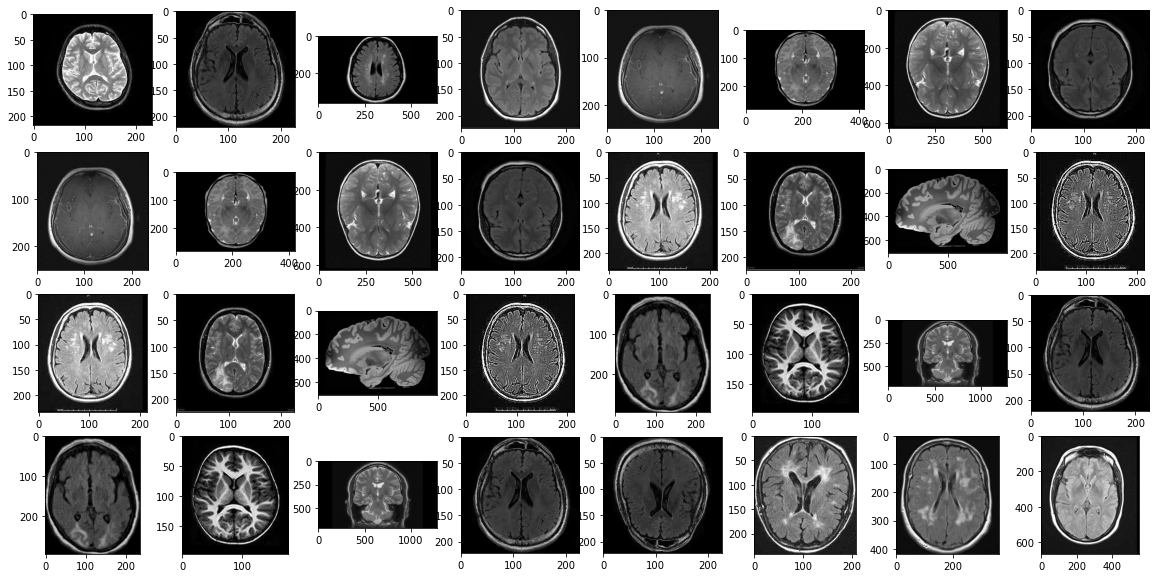

In [6]:
# Read Images (Healthy)
indx = 0
healthy_images = []

for idx, img in enumerate(os.listdir(HEALTHY_IMAGE_PATH)):    
    # Loading the image
    img = load_img(HEALTHY_IMAGE_PATH + img)
    healthy_images.append(img)
    
print('Sample of healthy images in data:', idx + 1)

nrows, ncols = 4, 8 #print first 10 images
f, axs = plt.subplots(nrows, ncols, figsize=(20,10))
for i in range(nrows):
    for j in range(ncols):
        indx = (i * nrows) + j
        axs[i, j].imshow(healthy_images[indx], cmap="gray")

## 5. Data Preprocessing

In [7]:
# Split shape field to length, height, and channels
df['shape_x'] = df['shape'].str.replace('(', '').str.replace(')', '').str.split(',').str[0]
df['shape_y'] = df['shape'].str.replace('(', '').str.replace(')', '').str.split(',').str[1]
df['shape_layer'] = df['shape'].str.replace('(', '').str.replace(')', '').str.split(',').str[2]

df.head(5)

,Unnamed: 0,image,class,format,mode,shape,shape_x,shape_y,shape_layer
0,0,Cancer (1).jpg,tumor,JPEG,RGB,"(512, 512, 3)",512,512,3
1,2,Cancer (1).tif,tumor,TIFF,RGB,"(256, 256, 3)",256,256,3
2,3,Cancer (10).jpg,tumor,JPEG,RGB,"(512, 512, 3)",512,512,3
3,4,Cancer (10).tif,tumor,TIFF,RGB,"(256, 256, 3)",256,256,3
4,5,Cancer (100).jpg,tumor,JPEG,RGB,"(512, 512, 3)",512,512,3


## 6. Exploratory Data Analysis (EDA)

### Features Diagram:
#### Findings:
* The output class is slightly imbalanced, but acceptable.
* Images have different file extensions: JPEG, TIF, PNG

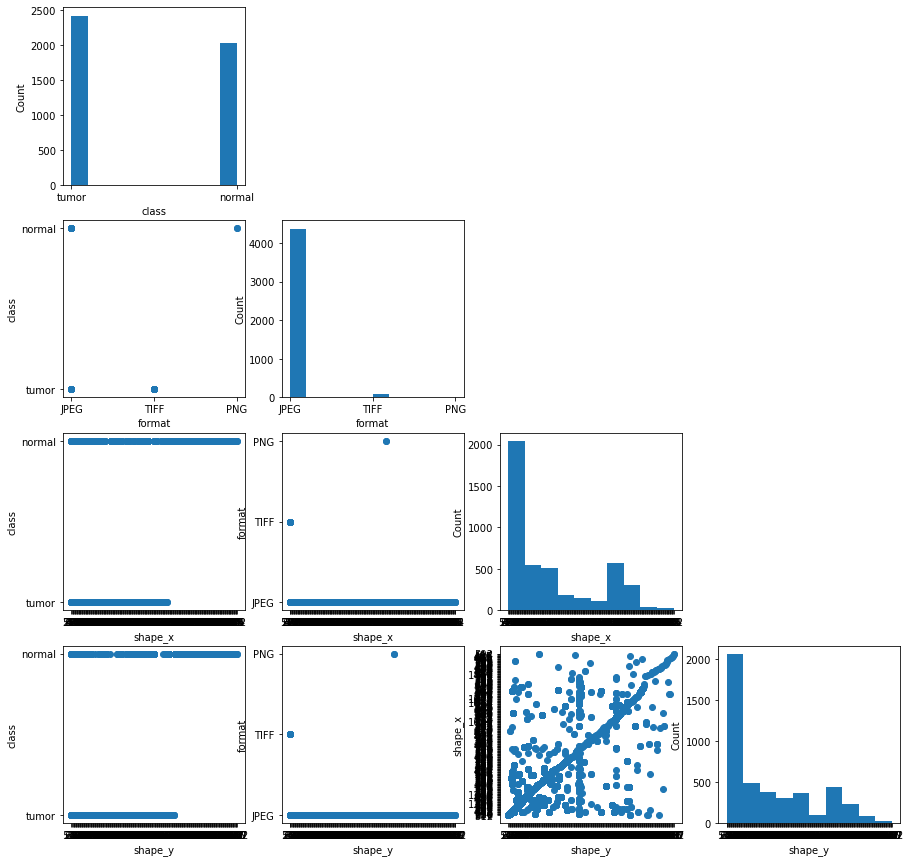

In [8]:
variables = ['class', 'format', 'shape_x', 'shape_y']

scatterplotmatrix(
    df[variables].values,
    names=variables,
    figsize=(15,15), alpha=1
);

## 7. Image Preprocessing
* Convert RGB image to grayscale
* Resize images to 224 * 224

### 7.1 Process Cancer Images and Show Processed Results

Sample of cancer images in data: 2513


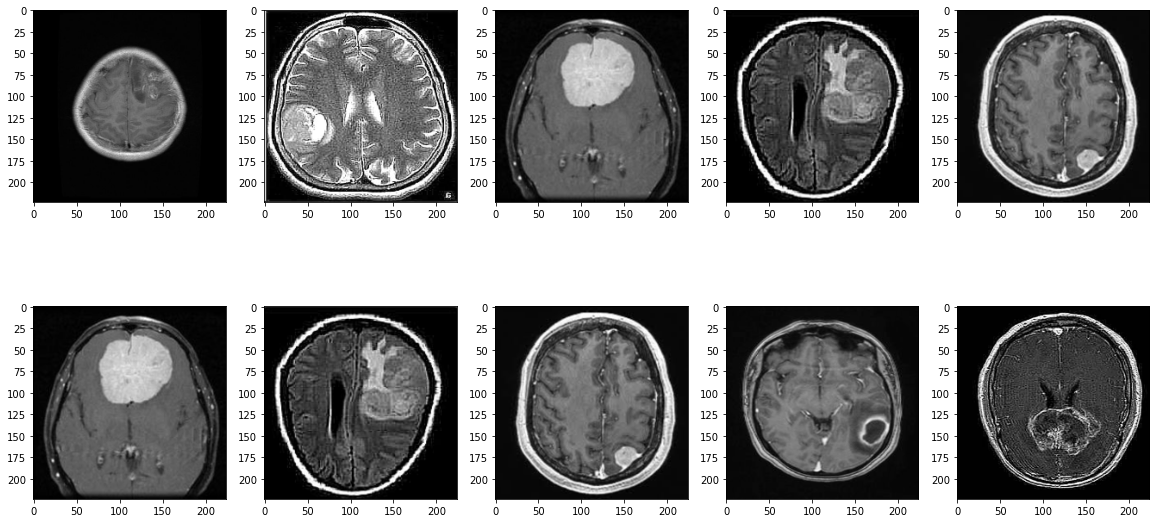

In [9]:
# Read Cancer Images

indx = 0
cancer_images = []

for idx, img in enumerate(os.listdir(CANCER_IMAGE_PATH)):

    # Loading the image and converting to grayscale
    img = Image.open(CANCER_IMAGE_PATH + img).convert('L')
    
    # transform image to array
    img = img_to_array(img)
        
    img_resize = tf.image.resize(img, size=(224, 224))
    cancer_images.append(img_resize)
    
print('Sample of cancer images in data:', idx + 1)

nrows, ncols = 2, 5 # print first 10 images
f, axs = plt.subplots(nrows, ncols, figsize=(20,10))
for i in range(nrows):
    for j in range(ncols):
        indx = (i * nrows) + j
        axs[i,j].imshow(cancer_images[indx], cmap="gray")
        
# Instantiate the dynamic number of labels associated with images
cancer_labels = [1] * len(cancer_images)

### 7.2 Process Normal Images and Show Processed Results

Sample of healthy images in data: 2087


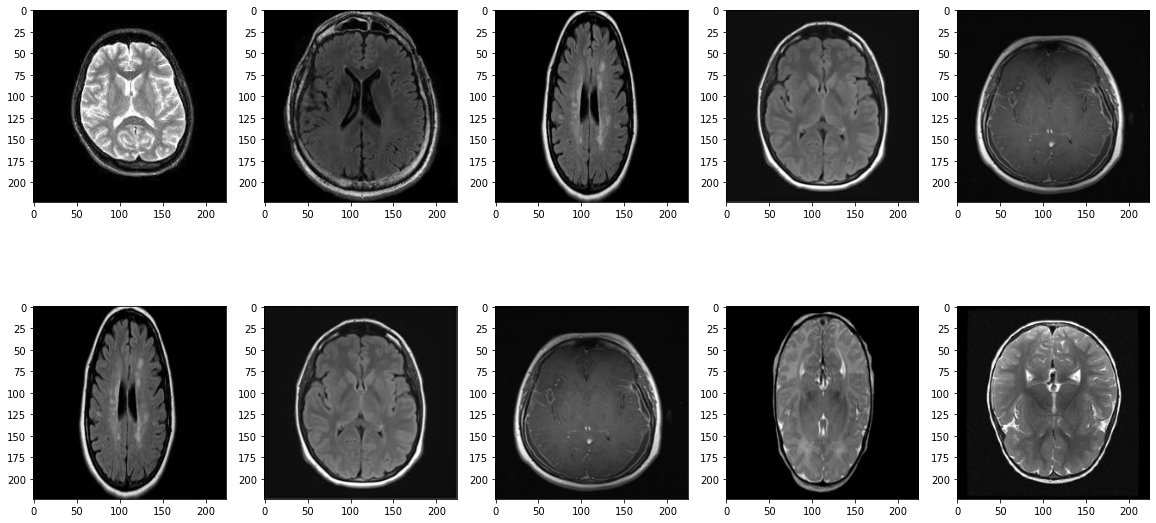

In [10]:
# Read Images (Healthy)
indx = 0
healthy_images = []

for idx, img in enumerate(os.listdir(HEALTHY_IMAGE_PATH)):
    
    # Loading the image and converting to grayscale
    img = Image.open(HEALTHY_IMAGE_PATH + img).convert('L')
    
    # transform image to array
    img = img_to_array(img)
        
    img_resize = tf.image.resize(img, size=(224, 224))
    healthy_images.append(img_resize)
    
print('Sample of healthy images in data:', idx + 1)

nrows, ncols = 2, 5 #print first 10 images
f, axs = plt.subplots(nrows, ncols, figsize=(20,10))
for i in range(nrows):
    for j in range(ncols):
        indx = (i * nrows) + j
        axs[i, j].imshow(healthy_images[indx], cmap="gray")
        
# Instantiate the dynamic number of labels associated with images
healthy_labels = [0] * len(healthy_images)

In [11]:
total_images = copy.deepcopy(cancer_images)
total_labels = copy.deepcopy(cancer_labels)

total_images.extend(healthy_images)
total_labels.extend(healthy_labels)

In [12]:
len(total_labels)

4600

## 8. Define plotting functions

In [13]:
def plot_loss_and_accuracy_curve(history):
    x_arr = np.arange(len(history['loss'])) + 1

    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, history['loss'], '-o', label='Train loss')
    ax.plot(x_arr, history['val_loss'], '--<', label='Validation loss')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, history['binary_accuracy'], '-o', label='Train acc.')
    ax.plot(x_arr, history['val_binary_accuracy'], '--<', label='Validation acc.')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Accuracy', size=15)
    
    plt.show()

## 9. Finding the duplicates within the total_images list

During image inspection, we noticed there are several duplicate images. We will be using image hash library to identify duplicates:
1. Generate hash code for each image.
2. Load the hash code to a dictionary.
3. For each duplicate images, only keep one file.
4. After de-duplicate process, the new image count drops to 4,009 (vs. 4,600).
5. Among 4,009 images, 1,721 are normal images, and 2,288 are cancer images.

### 9.1 Create image hash and remove duplicates

In [14]:
# Generate hash for each image.
hashed_images = []

for i in range(len(total_images)):
    hashed_images.append((str(average_hash(array_to_img(total_images[i]), hash_size=64)), i))

In [15]:
# Load hash code into a dictionary and find unique values.
unique_items = list(dict(hashed_images).values())

len(unique_items)

3985

In [16]:
# Filtering the images and labels list containing only the unique items
total_images_deduped = [total_images[idx] for idx in unique_items]
total_labels_deduped = [total_labels[idx] for idx in unique_items]

total_images_deduped = np.array(total_images_deduped)
total_labels_deduped = np.array(total_labels_deduped)

In [17]:
np.unique(np.array(total_labels_deduped), return_counts=True)

(array([0, 1]), array([1700, 2285]))

### 9.2 Confirmation from first 10 images that duplications are removed

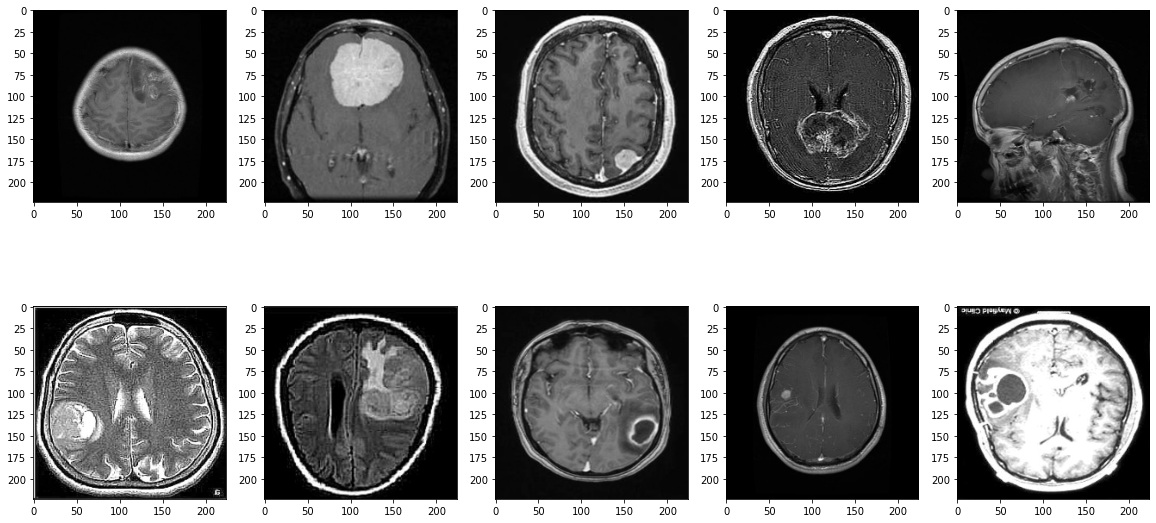

In [18]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20,10))

ax[0, 0].imshow(total_images_deduped[0], cmap="gray")
ax[1, 0].imshow(total_images_deduped[1], cmap="gray")
ax[0, 1].imshow(total_images_deduped[2], cmap="gray")
ax[1, 1].imshow(total_images_deduped[3], cmap="gray")
ax[0, 2].imshow(total_images_deduped[4], cmap="gray")
ax[1, 2].imshow(total_images_deduped[5], cmap="gray")
ax[0, 3].imshow(total_images_deduped[6], cmap="gray")
ax[1, 3].imshow(total_images_deduped[7], cmap="gray")
ax[0, 4].imshow(total_images_deduped[8], cmap="gray")
ax[1, 4].imshow(total_images_deduped[9], cmap="gray")

plt.show()

In [19]:
# Splitting and shuffling our training and testing data for our model
X_train, X_test, y_train, y_test = train_test_split((total_images_deduped / 255), total_labels_deduped, test_size=0.20, 
                                                    shuffle=True, random_state=101)

## 10. Build CNN Model

In [20]:
# We want to confirm the shape of our training data to understand what input shape to pass inside our layers
X_train.shape

(3188, 224, 224, 1)

In [21]:
def build_cnn_model(learning_rate=0.01):
    """Build a TF Convolutional Neural Network using Keras.

    Args:
    learning_rate: The desired learning rate for Adam.

    Returns:
    model: A tf.keras model (graph).
    """
    
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    # Build a model using keras.Sequential.
    model = tf.keras.Sequential()
    
    # Keras 2D Convolutional Layers and MaxPooling to specify batch size, relu activation function, and input shape
    model.add(tf.keras.layers.Conv2D(16, (5,5), padding='same', activation="relu",input_shape=(224, 224, 1)))
    model.add(tf.keras.layers.MaxPooling2D((2,2)))  
    
    model.add(tf.keras.layers.Conv2D(32, (3,3), padding='same', activation="relu",input_shape=(224, 224, 1)))
    model.add(tf.keras.layers.MaxPooling2D((2,2)))   
    model.add(tf.keras.layers.Conv2D(32, (3,3), padding='same', activation="relu",input_shape=(224, 224, 1)))
    model.add(tf.keras.layers.MaxPooling2D((2,2))) 
    
    model.add(tf.keras.layers.Conv2D(64, (3,3), padding='same', activation="relu",input_shape=(224, 224, 1)))
    model.add(tf.keras.layers.MaxPooling2D((2,2)))
    
    model.add(tf.keras.layers.Conv2D(128, (3,3), padding='same', activation="relu",input_shape=(224, 224, 1)))
    model.add(tf.keras.layers.MaxPooling2D((2,2))) 
    
    model.add(tf.keras.layers.Dropout(0.5))
    

    # Keras Flatten layer for our images
    model.add(tf.keras.layers.Flatten())
    
    # Add dense layers
    model.add(tf.keras.layers.Dense(units=512, activation="relu"))
    model.add(tf.keras.layers.Dense(units=256, activation="relu"))
    model.add(tf.keras.layers.Dense(units=128, activation="relu"))

    # This layer constructs the linear set of parameters for each input feature
    # (as well as a bias), and applies a sigmoid to the result.
    model.add(tf.keras.layers.Dense(
      units=1,
      use_bias=True,               
      activation="sigmoid"
    ))

    # Use the Adam optimizer for our CNN - better performance in nearly all cases
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(loss='binary_crossentropy', 
                optimizer=optimizer, 
                metrics=[tf.keras.metrics.BinaryAccuracy()])

    return model

In [22]:
model_cnn = build_cnn_model(learning_rate=0.001)

# Fit the model.
history = model_cnn.fit(
  x = X_train,
  y = y_train,
  epochs=10,   
  validation_split=0.25,
  verbose=1 
  )

# Convert the return value into a DataFrame so we can see the train loss 
# and binary accuracy after every epoch.
history = pd.DataFrame(history.history)
display(history[-10:])

2022-12-01 15:32:57.495632: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/10
75/75 [==============================] - 16s 206ms/step - loss: 0.6129 - binary_accuracy: 0.6767 - val_loss: 0.4802 - val_binary_accuracy: 0.7792
Epoch 2/10
75/75 [==============================] - 16s 209ms/step - loss: 0.4247 - binary_accuracy: 0.8076 - val_loss: 0.4241 - val_binary_accuracy: 0.8055
Epoch 3/10
75/75 [==============================] - 16s 211ms/step - loss: 0.3198 - binary_accuracy: 0.8591 - val_loss: 0.3127 - val_binary_accuracy: 0.8733
Epoch 4/10
75/75 [==============================] - 16s 208ms/step - loss: 0.2712 - binary_accuracy: 0.8908 - val_loss: 0.2989 - val_binary_accuracy: 0.8620
Epoch 5/10
75/75 [==============================] - 16s 208ms/step - loss: 0.2269 - binary_accuracy: 0.9092 - val_loss: 0.2409 - val_binary_accuracy: 0.9147
Epoch 6/10
75/75 [==============================] - 16s 208ms/step - loss: 0.1864 - binary_accuracy: 0.9322 - val_loss: 0.2202 - val_binary_accuracy: 0.9097
Epoch 7/10
75/75 [==============================] - 17s 22

,loss,binary_accuracy,val_loss,val_binary_accuracy
0,0.612932,0.676704,0.480237,0.779172
1,0.424678,0.807612,0.424075,0.805521
2,0.319803,0.859055,0.312686,0.873275
3,0.271150,0.890841,0.298931,0.861982
4,0.226917,0.909243,0.240897,0.914680
5,0.186404,0.932246,0.220188,0.909661
6,0.161128,0.938101,0.285901,0.875784
7,0.147287,0.940611,0.156718,0.936010
8,0.118084,0.955667,0.174068,0.933501
9,0.121039,0.953994,0.197541,0.924718


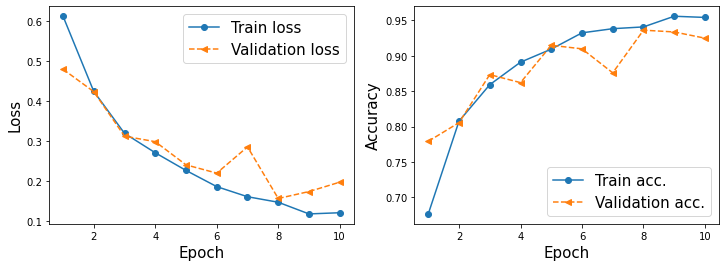

In [23]:
plot_loss_and_accuracy_curve(history)

## 11. Data Augmentation

In [24]:
CONTRAST_FACTOR = 3
DELTA = 0.2

def process_data_augmentation(images, y):
    """ Split data into train, validation and test sets; apply transformaions and augmentations
    
    Params:
    -------
    images  (np.ndarray): Images of shape (N, 224, 224, 1)
    y (np.ndarray): Labels of shape (N,)   
    
    Returns:
    --------
    X_train_with_augm (np.ndarray): Train images of shape (N_train, 224, 224, 1)
    y_train_with_augm (np.ndarray): Train labels of shape (N_train,)
    
    """
    
    ### image augmentation on training data ###
    ###########################################
    # adjust brightness
    X_train_augm = tf.image.adjust_brightness(X_train, delta=DELTA)
    
    # adjust contrast
    X_train_augm = tf.image.adjust_contrast(X_train_augm, contrast_factor=CONTRAST_FACTOR)

    # random flip
    X_train_augm = tf.image.random_flip_left_right(X_train_augm)
    
    # concatenate original X_train and augmented X_train data
    X_train_with_augm = tf.concat([X_train, X_train_augm],axis=0)
    
    # concatenate y_train (note the label is preserved)
    y_train_augm = y_train
    y_train_with_augm = tf.concat([y_train, y_train_augm],axis=0)
    
    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train_with_augm)[0], dtype=tf.int32))
    X_train_with_augm = tf.gather(X_train_with_augm, shuffle)
    y_train_with_augm = tf.gather(y_train_with_augm, shuffle).numpy() #also transforms y_train to numpy array
    
    return X_train_with_augm, y_train_with_augm

In [25]:
X_train_with_augm, y_train_with_augm = process_data_augmentation(X_train, y_train)

In [26]:
print(X_train.shape)
print(X_train_with_augm.shape)
print(y_train.shape)
print(y_train_with_augm.shape)

(3188, 224, 224, 1)
(6376, 224, 224, 1)
(3188,)
(6376,)


In [27]:
model_cnn_augm = build_cnn_model(learning_rate=0.001)

# Fit the model.
history = model_cnn_augm.fit(
  x = X_train_with_augm,
  y = y_train_with_augm,
  epochs=20,   
  validation_split=0.25,
  verbose=1 
  )

# Convert the return value into a DataFrame so we can see the train loss 
# and binary accuracy after every epoch.
history = pd.DataFrame(history.history)
display(history[-10:])

Epoch 1/20
150/150 [==============================] - 32s 213ms/step - loss: 0.5649 - binary_accuracy: 0.7110 - val_loss: 0.4384 - val_binary_accuracy: 0.8049
Epoch 2/20
150/150 [==============================] - 32s 211ms/step - loss: 0.3507 - binary_accuracy: 0.8476 - val_loss: 0.2822 - val_binary_accuracy: 0.8871
Epoch 3/20
150/150 [==============================] - 32s 210ms/step - loss: 0.2404 - binary_accuracy: 0.9030 - val_loss: 0.2501 - val_binary_accuracy: 0.9053
Epoch 4/20
150/150 [==============================] - 32s 213ms/step - loss: 0.1993 - binary_accuracy: 0.9237 - val_loss: 0.2068 - val_binary_accuracy: 0.9279
Epoch 5/20
150/150 [==============================] - 32s 212ms/step - loss: 0.1451 - binary_accuracy: 0.9471 - val_loss: 0.1573 - val_binary_accuracy: 0.9504
Epoch 6/20
150/150 [==============================] - 32s 216ms/step - loss: 0.1258 - binary_accuracy: 0.9534 - val_loss: 0.1524 - val_binary_accuracy: 0.9442
Epoch 7/20
150/150 [==========================

,loss,binary_accuracy,val_loss,val_binary_accuracy
10,0.064678,0.975742,0.093501,0.972396
11,0.050959,0.981179,0.095599,0.974279
12,0.053093,0.979506,0.129719,0.972396
13,0.041599,0.984107,0.107516,0.978670
14,0.057636,0.978670,0.131043,0.967378
15,0.044835,0.982434,0.118710,0.974906
16,0.033937,0.989544,0.132720,0.972396
17,0.030713,0.989962,0.171366,0.964868
18,0.035905,0.987871,0.093819,0.968005
19,0.025319,0.991635,0.106504,0.974906


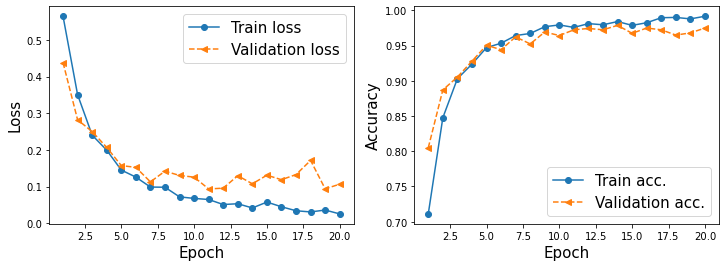

In [28]:
plot_loss_and_accuracy_curve(history)

### 11.1 Reduce the Number of Epochs to 10
After inspecting the result of the validation and accuracy loss, we believe the model is overfitting after 8 epochs. Reduce the number of epochs and train the model again.

In [29]:
model_cnn_augm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 32)       0

In [30]:
model_cnn_augm = build_cnn_model(learning_rate=0.001)

# Fit the model.
history = model_cnn_augm.fit(
  x = X_train_with_augm,
  y = y_train_with_augm,
  epochs=10,   
  validation_split=0.25,
  batch_size=32,
  verbose=1 
  )

# Convert the return value into a DataFrame so we can see the train loss 
# and binary accuracy after every epoch.
history = pd.DataFrame(history.history)
display(history[-10:])

Epoch 1/10
150/150 [==============================] - 33s 221ms/step - loss: 0.5649 - binary_accuracy: 0.7110 - val_loss: 0.4384 - val_binary_accuracy: 0.8049
Epoch 2/10
150/150 [==============================] - 33s 217ms/step - loss: 0.3507 - binary_accuracy: 0.8476 - val_loss: 0.2822 - val_binary_accuracy: 0.8871
Epoch 3/10
150/150 [==============================] - 32s 215ms/step - loss: 0.2404 - binary_accuracy: 0.9030 - val_loss: 0.2501 - val_binary_accuracy: 0.9053
Epoch 4/10
150/150 [==============================] - 34s 230ms/step - loss: 0.1993 - binary_accuracy: 0.9237 - val_loss: 0.2068 - val_binary_accuracy: 0.9279
Epoch 5/10
150/150 [==============================] - 35s 236ms/step - loss: 0.1451 - binary_accuracy: 0.9471 - val_loss: 0.1573 - val_binary_accuracy: 0.9504
Epoch 6/10
150/150 [==============================] - 33s 221ms/step - loss: 0.1258 - binary_accuracy: 0.9534 - val_loss: 0.1524 - val_binary_accuracy: 0.9442
Epoch 7/10
150/150 [==========================

,loss,binary_accuracy,val_loss,val_binary_accuracy
0,0.564886,0.711000,0.438439,0.804893
1,0.350659,0.847553,0.282156,0.887077
2,0.240362,0.902969,0.250086,0.905270
3,0.199348,0.923672,0.206845,0.927854
4,0.145057,0.947093,0.157314,0.950439
5,0.125804,0.953367,0.152374,0.944166
6,0.098666,0.964241,0.112832,0.962359
7,0.098107,0.967169,0.141990,0.952321
8,0.071861,0.976788,0.130332,0.969260
9,0.067658,0.979297,0.125660,0.964241


In [31]:
model_cnn_augm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 32)       0

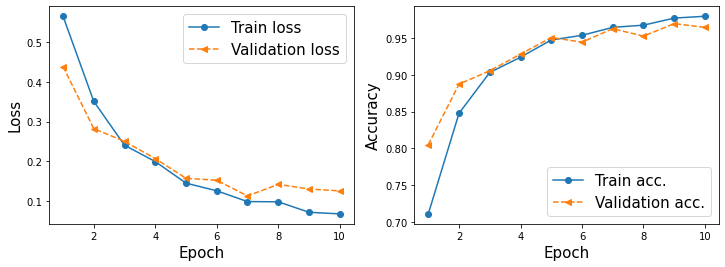

In [32]:
plot_loss_and_accuracy_curve(history)

## 12. Validate Final Model Accuracy Against Test Dataset

In [33]:
test_predictions = np.array((model_cnn_augm.predict(X_test) > 0.50).astype(int))
accuracy = sum(1 for x, y in zip(test_predictions, y_test) if x == y) / len(y_test)

print(f"CNN Model accuracy: {round(accuracy, 3) * 100}%.")

CNN Model accuracy: 96.1%.


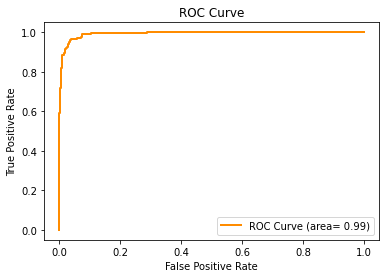

In [34]:
y_pred = model_cnn_augm.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC Curve (area= %0.2f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

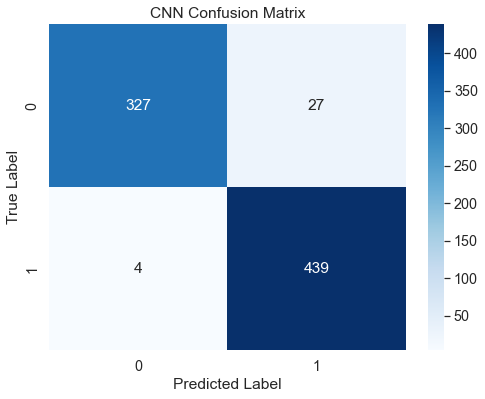

In [35]:
sns.set(font_scale=1.3)
fig, ax = plt.subplots(figsize = (8, 6))

conf_matrix = sns.heatmap(confusion_matrix(y_test, test_predictions), annot= True, fmt = '.0f', cmap='Blues')
conf_matrix.set(ylabel = 'True Label', xlabel = 'Predicted Label', title = 'CNN Confusion Matrix')

plt.show()

In [36]:
print(classification_report(
    y_test, test_predictions, 
    target_names=['healthy', 'tumor'], 
    sample_weight=None, 
    digits=2, 
    output_dict=False, 
    zero_division='warn'))

              precision    recall  f1-score   support

     healthy       0.99      0.92      0.95       354
       tumor       0.94      0.99      0.97       443

    accuracy                           0.96       797
   macro avg       0.96      0.96      0.96       797
weighted avg       0.96      0.96      0.96       797

